# Deep Neural Network Recommender for Weibo Search

**Directory**
1. Abstract
2. Background
3. Motivation
4. Model
5. Context Selection

## 1. Abstract
* We tend to improve the recommender system performance by establishing a sophisticated hybernated combining both embedding and deep learning for both user looklike and the query history to represents user preference.

* In this experiment, we will test the system at a high level and focus on the dramatic performance improvements brought by deep learning. We adopt siamease network to train the model and decrease triplet loss as the strategy adopted in face recognition training.

* A deep similarity discrimination model will be established, we will first test the model to see if it has a significant impact on our business based on offline test and then we may upload it online and do the A/B test to see if it can really help to improve the CTR.

## 2. Background
Recommender system based on deep learning has been a recent trend in industry. Big commpanies like Spotify, Google, Netflex, Factbook have already adopted deep learning in the recommender system and have recept awesome pay-off. Since Weibo Search is essentially a recommender system, we consider adopting this technique on our business.

## 3.Motivation
1. Since Weibo Search used to adopt the LinUCB, a kind of recommender algorithm abstract from contextual bandit problem, it would suffer from a systematic inaccuracy intrinsic to the tag strategy. However, here the neural network approach will build more sophisticated model for both the users and hot phrases based on word embedding. 
2. Comparaed with a linear method used in LinUCB algorithm, the deep neural network architechture will be able to capture the interactive feature both within and between the user attributes and the features of hot phrases. 
3. The Deep Neural Network approach will include users' query history, which is a way to find the active information retrival behavior and may help to correct the selection bias of simply based on tags.

## 4.Model
System overview

The overall framework of our recommendation system is illustrated in Figure 1. The system is comprised of one network.
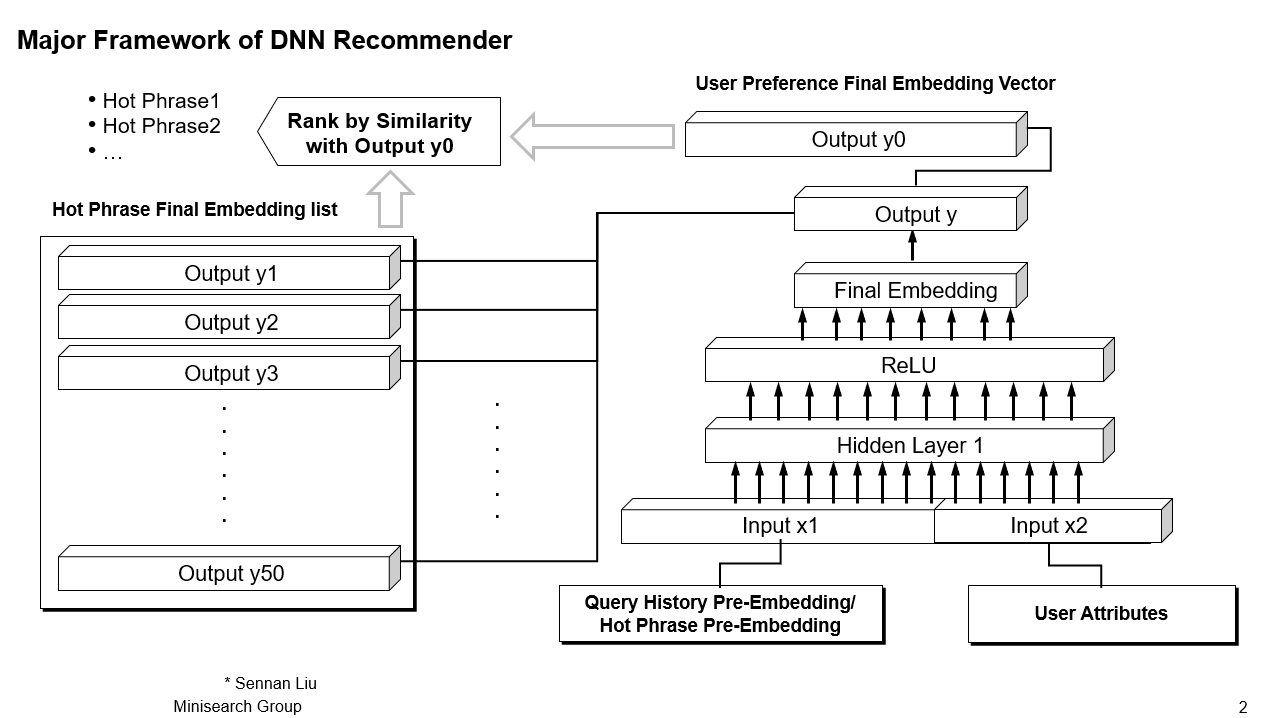

**Figure 1: Recommendation system architecture**

### 4.1 Phrase Embedding
* To effectively represent all the natural language text, including the search and pick history and feature of hot phrases, we consider to embed the phrase to dipict its latent features. Also, Inspired by the contineous bag of words model, we than would be able to first tokenize each query into unigrams and bigrams and each token is embedded, here we adopt an open sourece embedding matrix.

For each sentence $s_i$, we would tokenize it  and obtain $list_{i}$

$$List_i = ['word1','word2',\cdots,'wordm']$$

Then we simply remove stop words in the list and filter it with TF-IDF method, fetch top $n$ important words.

$$Effective\ List_i = ['word1','word2',\cdots,'wordn']$$

Now we do the embedding:

$$\vec{Woh_k} = dict['wordk']$$

where $k\in\{1,2,\cdots,n\}$

$dict$ is the hash table that stores the one-hot encoding representation of all words

$$\vec{e_k} = E \vec{Woh_k}$$

where

$E$ is the open source word embedding matrix

$\vec{Woh_k}$ is the one hot representation of certain unigram or bigram in the dictory

$\vec{e_k}$ is the embedding vector. However, in the real training, we tend to simply pick the index and pick out the corresponding embedding vector.

After all these, we then average all the vectors to obtain the embedding of the phrase:

$$\vec{e_i} = \frac{1}{m}\times\Sigma^n_{k=1}\vec{e_k}$$

* Then after elimiting stopwords, we simply calculate the avereage embedding vector of the bage of words.

### 4.2 Recommender as Similarity Calculation
* Traditionally, we would consider the recommeder as a box which select a few words from a large corpus, but here our tesk is to pick out the most effective hot phrases from a small pool (within 50 words) to certain user, then we may consider to find the similarity between a preference vector $\vec{p_u}$, which represents the users' preference and the embedding vector $\vec{e_i}$ as:
$$sim(\vec{p_u},\vec{e_i}) = \parallel \vec{p_u}- \vec{e_i} \parallel^2$$

* At serving time we need to fetch the most closest N classes (hot phrases) in order to choose the top N to present to the user. We will store the embedding vector of hot phrases and user preference in hash table. Then this becomes an nearest neighbour search.

### 4.3 Training Strategy
* To effectively train the model with many times of negative samples but only few positive samples ("imbalance problem"), we deciside to use Siamese Network and Triplet Loss to train out model. 


#### 4.3.1 Siamese Network
* A Siamese network is a kink of neural network that simutaneousely receive two inputs and calculate the outputs. Since the two outputs share the same weights, we call them 'Siamese'. This is illustrated in Figure 2

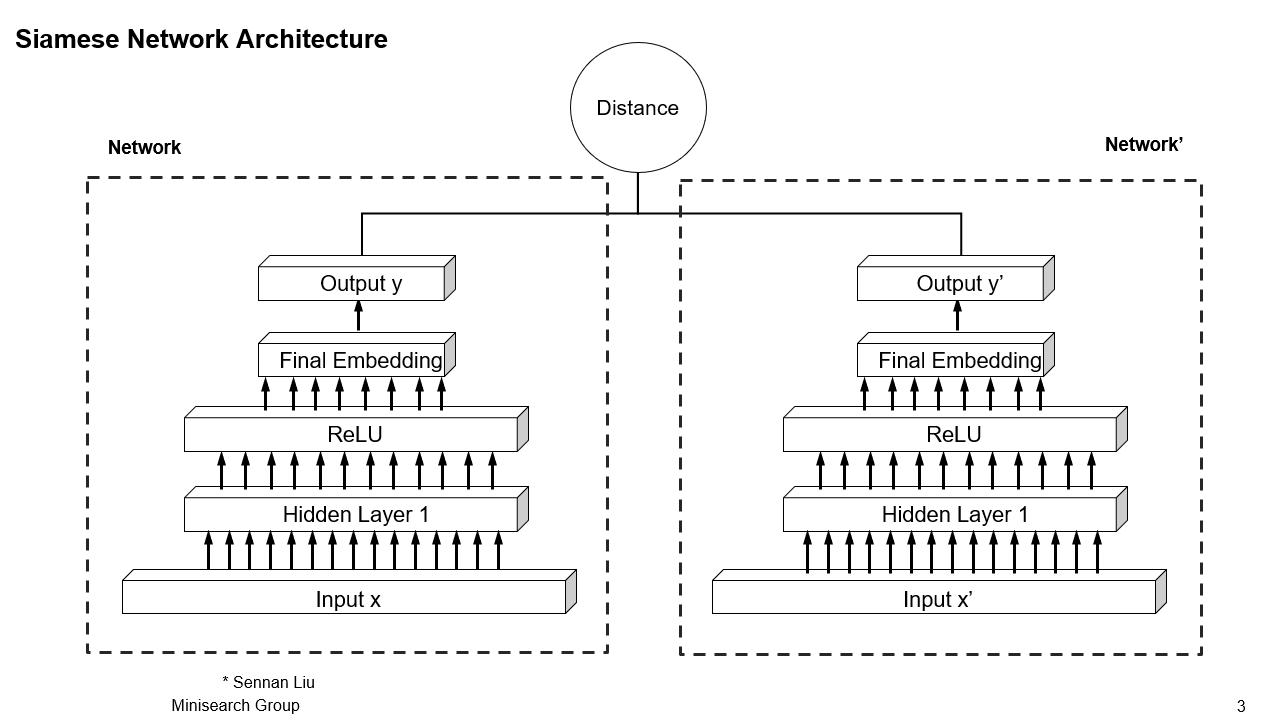
**Figure 2: A demo of Siamese network**


#### 4.3.2 Triplet Loss
* Since we pick the words based on the similarity, we need to define triple loss as the similarity of possitive example minus the negative examples plus epsilon, a small float number which can be perceived as a margin in order to distinguish the positive samples from the negative ones and speed up the training. 
* This is just like what we have done in face recongnition, where we want the classifier to distinguish the positive and the negative as far as possible. We define the triple loss :

$$Loss = max( C_i - D_i + \epsilon, 0 )$$

where

$$C_i =  sim(\vec{P_i},\vec{N_i})$$

$$D_i =  sim(\vec{P_i},\vec{F_i})$$

and $\epsilon$ is a hyperparameter that is used in order to distinguish the positive sample from the negative ones.

where $N_i$ is the possitive sample output and $F_i$ is the negative sample output. This is illustrated in Figure 3


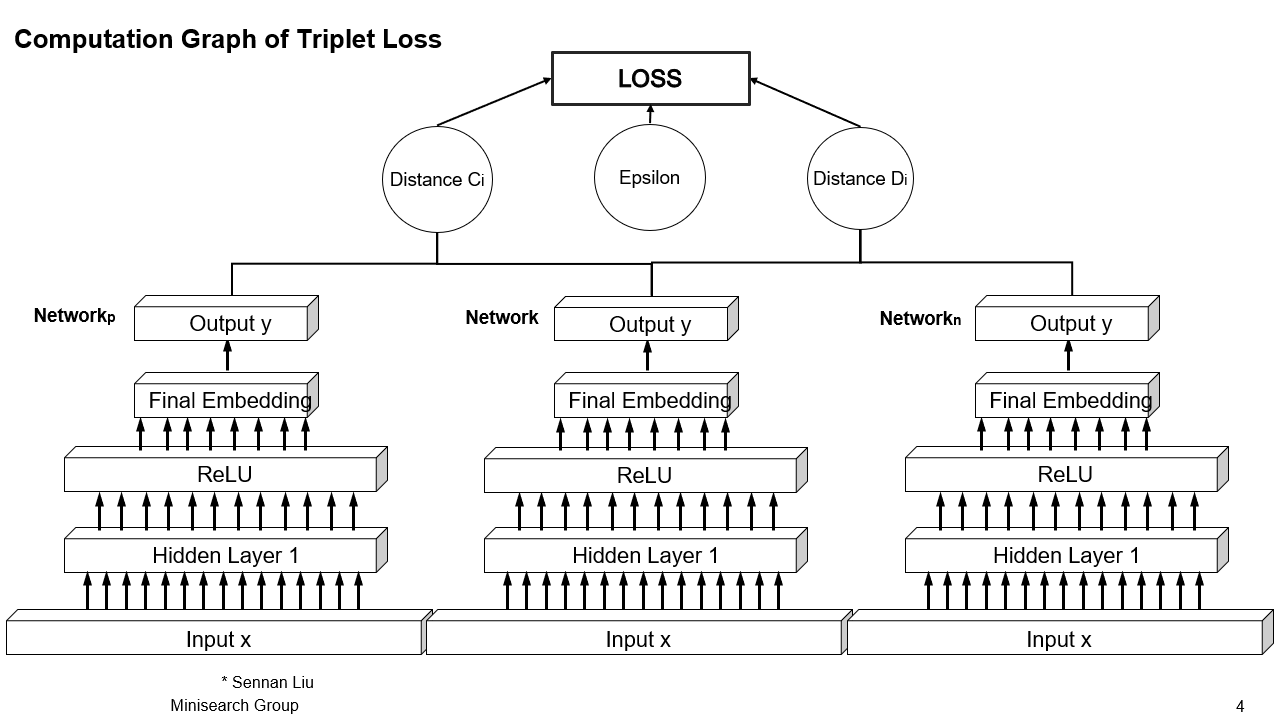
**Figure3: Triplet loss**


#### 4.3.3 Semi-hard stretagy
* In order to improve the efficiency of our training samples, we do not pick all the negative examples and The loss encourages the positive distances (between a pair of embeddings with the same labels) to be smaller than the minimum negative distance among which are at least greater than the positive distance plus the margin constant (called semi-hard negative) in the mini-batch. If no such negative exists, uses the largest negative distance instead. 

* We denote the input_i as $\vec{e^{in}_i}$, the output as $\vec{e^{out}_i}$, the binary lables as $\vec{Label_i}$.


$$
\left[
\begin{matrix}
  Inputs & Outputs & Label(y_{i}) \\
  \vec{e^{in}_1} & \vec{e^{out}_1} & Lable_1 \\
  \vec{e^{in}_2} & \vec{e^{out}_2} & Lable_2 \\
  \vec{e^{in}_3} & \vec{e^{out}_3} & Lable_3 \\
  \vdots & \vdots & \vdots \\
  \vec{e^{in}_i} & \vec{e^{out}_i} & Lable_i \\
  \vdots & \vdots & \vdots \\
  \vec{e^{in}_{m-1}} & \vec{e^{out}_{m-1}} & Lable_{m-1} \\
  \vec{e^{in}_{m}} & \vec{e^{out}_{m}} & Lable_{m} 
\end{matrix}
\right]
$$


$$ m_M = argmin_{i \in M} sim(P_i,F_i) $$

$$ m_M = argmax_{i \in M} sim(P_i,N_i) $$


$$ Loss_M = max( C_{m_M} - D_{m_M} + \epsilon, 0 )$$


where $M$ denotes all the samples in the batch.
$Loss_M$, $C_{m_M}$, $D_{m_M}$ denotes the loss of barch M and the loss , the near distance adn the far distance in batch M respectively.


#### 4.3.4 Batches and labels
* Here since we cannot ensure a uniform distribution of all the click in a group of hot phrases, we simply concatenate the pre-embeddings of user query history and all the pre-embeddings of hotphrases. Thus in each batch, we have in total 51 samples with at most 2 positive samples. 

* One of the possitive samples is the sample of user query history , we denote it as $\vec{p_u}$. The other possitive sample is the clicked phrase. All other inputs are labeled as negative. 


$$
\left[
\begin{matrix}
  Pre-Embeddings:e_i & Final-Embedding:e_o & Label(y_i) \\
  \vec{e^{in}_1} & \vec{e^{out}_1} & 0 \\
  \vec{e^{in}_2} & \vec{e^{out}_2} & 0 \\
  \vdots & \vdots & \vdots \\
  \vec{e^{in}_i} & \vec{e^{out}_i} & 0 \\
  \vdots & \vdots & \vdots \\
  \vec{e^{in}_j} & \vec{e^{out}_j} & 1 \\
  \vdots & \vdots & \vdots \\
  \vec{e^{in}_{50}} & \vec{e^{out}_{50}} & 0 \\
  \vdots & \vdots & \vdots \\
  \vec{e^{in}_u} & \vec{e^{out}_u} & 1 
\end{matrix}
\right]
$$

where $j$ denotes the index of the hot phrase clicked, $u$ denotes the sample of the user himself.


#### 4.3.5 Inputs
* We simply concatenate all the user query history and the user features in a 1d vector, in this version, the pre-embedding query history (or the pre-embedding of hot phrases) is 125 dimensions in total. (which means $e^{in}_i \in R^{125}$, $X_{batch} \in R^{51\times125} $)

* $\vec{e^{in}_u} = [\vec{e_{query\ history}}, \vec{e_{user\ features}}]$

### 4.4 Model Architectures

* **In the base line model, we will put one hidden layer.** Then the architecture will be:
* $\vec{e^{in}}$→first hidden layer(120 dimension)→ReLU→flatten(100 dimensions)→$\vec{e^{out}}$

### 4.6 Metrics Methodology
Since we don't have real examples, we tend to measure the offline performance of our new recommender algorithm by NDCG measurement:

$$CG_k = \Sigma^{p}_{i = 1}rel_i$$

$$DCG_k = \Sigma^{p}_{i = 1}\frac{rel_i}{log_2(i+1)} = rel_1 + \Sigma^{p}_{i = 2}\frac{rel_i}{log_2(i+1)}$$

Where $i$ is the rank of the hot phrase, $k$ is the $k$ th phrase group in the dev or test set, $p$ is the number of recommended phrases we have

Here since we only know whether the user click or not, we form our own relavent measure as:

$$click\ efficiency_i =
\begin{cases}
0& \text{not click}\\
click\ num_k - click\ odr_i + 1& \text{click}
\end{cases}$$

where $click\ num_k$ is the total number of click in one phrase group, $click\ odr_i$ is the order of click in the phrase group.

$$rel_i = 2^{click\ efficiency_i} - 1$$

$$NDCG_k = \frac{DCG_k}{IDCG_k} $$

Then if we sort the relavent value in an descend order, we could obtain the ideal DCG score:

$$IDCG_k = \Sigma^{p}_{j = 1}\frac{rel_j}{log_2(j+1)}$$

where $rel_1$ is the largest among the rest ${rel_i}$, and $log_2(1+1)$ is the smallest among the rest ${log_2(j+1)}$

Finally we sum all the NDCG score and find its average value:

$$NDCG = \frac{\Sigma^{m}_{k = 1}NDCG_k}{m}$$

### 4.6 Hyperprameters Option
This is the most challenging part of our experiment. In order to exploite most of the knowledge we have, we tend to test as many combination as we can.

The hyperparameters woule be test from 6 dimensions, they are:

1. Embeddings:

 - star_pool(False) : Whether we need a star pool when we fetch the important words from the query sentences. If the value is true, then we need to switch th flag and add a star pool when we embedding a sentence.
 - event_pool(False) : Whether we need a event pool when we fetch the important words from the query sentences. If the value is true, then we need to switch th flag and add a event pool when we embedding a sentence.
 - embedding_kernel_obj(100d mini) : the embedding kernel file used to initialize the embedding object.
 - top_k_importance: fetch the top k importance words from the tokenized words filtered by TF-IDF and stopwords dictionary.
 
 
2. Sampling: 
 - query sample mode(window): 
                 the mode for extract the query samples. In total, there are three modes, which are:
                'window' means fetch all the query samples in a certain time window.
                'up_bnd' means fetch the query samples of each user but control the number of query within the bound.
                        For example, if the upper bound is 10, we know at most we would fetch 10 queries for a certain user.
                'equl' means fetch equal number of query samples from each user. For example, we would fetch latest 10
                        sampels for each user and ignore whether or not he or she is an active user.
                Among all the three mode, we preferentially fetch the most recent samples for each users.
 - query history sample mode(window): 
                 the mode for extracting the query history. In total, there are three modes, which are:
                'window' means fetch all the query history in a certain time window.
                'times' means fetch the query history of each user for how many times
                Among all the two mode, we preferentially fetch the most recent samples for each users.

3. Model
 - Topology(1 hidden(fc) ) : how does the newwork built, how many hidden layers and what is the funciton of each layers.

## 5. Context Selection
* We therefore found much better performance predicting the user's next watch, rather than predicting a randomly held-out watch (Figure 3). As a result, we "rollback" a user's history by choosing a random watch and only input actions the user took before the held-out label watch.

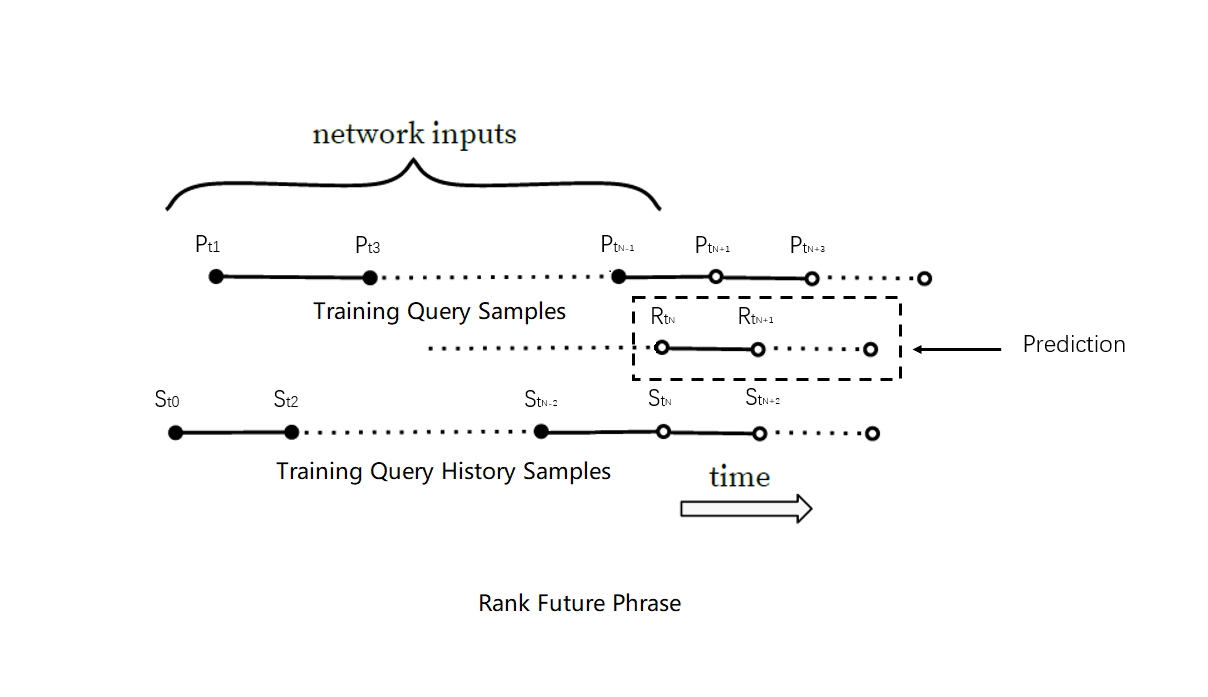
**Figure4: Context Selection**